In [ ]:
import pandas as pd

from preprocessing.cleaner import IndonesianNewsCleaner
from preprocessing.combiner import TextCombiner

import torch
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [ ]:
df = pd.read_csv('dataset/final_merge_dataset.csv')
df.head()

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source
0,"Viral Isu PHK Buruh Gudang Garam, Said Iqbal: ...",6 September 2025,https://nasional.kompas.com/read/2025/09/06/14...,"JAKARTA, KOMPAS.com – Presiden Konfederasi Se...",Said Iqbal,industri rokok,PT Gudang Garam,PHK massal,phk massal 2025 terbaru,kompas
1,"Gempa M 5,3 Guncang Pulau Doi Maluku Utara","Senin, 12 Agu 2024 21:58 WIB",https://news.detik.com/berita/d-7486691/gempa-...,"Gempa bumi berkekuatan magnitudo (M) 5,3 mengg...",pulau doi,gempa,NaN,NaN,NaN,detik
2,"Toko Emas Palsu di Riau Dibongkar Polisi, Perh...","Rabu, 30 Jul 2025 22:22 WIB",https://news.detik.com/melindungi-tuah-marwah/...,Satreskrim Polres Bengkalis membongkar praktik...,pemalsuan emas,emas palsu,polres bengkalis,polda riau,melindungi tuah marwah,detik
3,Minyakita Tak Sesuai Ukuran juga Ditemukan di ...,"Senin, 10 Mar 2025 23:15 WIB",https://news.detik.com/berita/d-7816829/minyak...,Polisi mendatangi salah satu gudang Minyakita ...,minyakita,kudus,NaN,NaN,NaN,detik
4,"Pimpin LDP, Sanae Takaichi Calon Kuat PM Perem...",4 Oktober 2025 | 14.00 WIB,https://www.tempo.co/internasional/pimpin-ldp-...,"Baca berita dengan sedikit iklan, klik di sin...",jepang,perdana-menteri,sanae-takaichi,perempuan,ldp,tempo


In [3]:
len(df)

80472

In [4]:
df["source"].unique()

array(['kompas', 'detik', 'tempo'], dtype=object)

In [5]:
for site in df["source"].unique():
    print(site)
    display(df[df["source"] == site]["Content"].sample(10).values)

kompas


array([' JAKARTA, KOMPAS.com - Polda Metro Jaya menggelar Operasi "Berantas Jaya-2025", dengan menggandeng TNI dan Pemprov Jakarta untuk memberantas aksi premanisme yang meresahkan masyarakat. Kapolda Metro Jaya Irjen Karyoto memimpin langsung apel gelar pasukan di Lapangan Silang Monas Selatan, Jakarta Pusat, pada Jumat (9/5/2025). Dalam kesempatan itu, ia menyebut, sebanyak 999 personel gabungan diturunkan dalam operasi ini, yang dilaksanakan selama 15 hari ke depan. “Operasi ini melibatkan 306 personel TNI dari Angkatan Darat, Laut, dan Udara, 663 dari Polri, dan 30 personel Pemerintah Provinsi Jakarta,” ujar Karyoto. Karyoto menekankan pentingnya strategi penegakan hukum yang terukur, serta pendekatan pre-emptive dan preventive untuk mencegah berkembangnya premanisme di Jakarta. “Operasi ini menyasar semua bentuk aksi premanisme, termasuk pemalakan liar di Monas, tawuran, hingga tindakan ormas yang meresahkan masyarakat,” ujar Karyoto. Data terbaru menunjukkan, kasus tawuran di Jak

detik


array(['Presiden Prabowo Subianto mencatatkan sejarah sebagai Presiden Republik Indonesia pertama yang menjadi tamu kehormatan dalam upacara peringatan Hari Nasional Prancis atau Bastille Day. Undangan resmi dari Presiden Prancis Emmanuel Macron ini menempatkan Indonesia dalam deretan negara-negara mitra strategis yang pernah mendapat kehormatan serupa dalam sejarah panjang Bastille Day. Dikutip Biro Sekretariat Presiden, Senin (14/7/2025), sejak pertama kali digelar secara resmi pada tahun 1880, Bastille Day bukan hanya perayaan Revolusi Prancis dan simbol semangat kebebasan, tetapi juga menjadi ajang diplomasi internasional. Tradisi mengundang pemimpin dunia sebagai tamu kehormatan dalam parade Bastille Day dimulai secara simbolik pada akhir abad ke-20.  Tamu kehormatan biasanya diberikan tempat di podium utama bersama Presiden Prancis dan tokoh penting negara tuan rumah, serta dapat menyertakan partisipasi simbolis militer dari negara tamu. Kehadiran Prabowo mengikuti jejak para pem

tempo


array(['Baca berita dengan sedikit iklan,  klik di sini  KOALISI Masyarakat Sipil untuk Reformasi Kepolisian mendesak Kapolri Jenderal Listyo Sigit Prabowo untuk mencabut Peraturan Kapolri Nomor 4 Tahun 2025 tentang Penindakan Aksi Penyerangan terhadap Polri. Koalisi menilai substansi Peraturan Kapolri (Perkap) itu melegitimasi penggunaan senjata api yang berlebihan oleh anggota Polri.  Baca berita dengan sedikit iklan,  klik di sini  “Semestinya, penggunaan senjata api merupakan tahapan terakhir sebagai upaya mencegah tindakan-tindakan yang dapat menyebabkan luka parah atau kematian anggota Polri atau anggota masyarakat,” ujar Program Manager Institute for Criminal Justice (ICJR), Iftitahsari, melalui siaran pers seperti dikutip pada Selasa, 7 Oktober 2025.  Scroll ke bawah untuk melanjutkan membaca   Baca berita dengan sedikit iklan,  klik di sini  Tita menjelaskan penggunaan senjata api sebelumnya diatur dalam Perkap No.1 Tahun 2009 yang mengedepankan prinsip nesesitas, proporsional

In [ ]:
df = df.copy()
df["Content_clean"] = df["Content"].apply(IndonesianNewsCleaner.clean)

TAG_COLS = [c for c in df.columns if c.startswith("tag")]

combiner = TextCombiner(
    text_cols=["Judul", "Content_clean", *TAG_COLS],
    sep=" "
)

df = combiner.combine_df(df, out_col="text_for_cluster")
df = df[df["text_for_cluster"].str.len() > 0].copy()

In [7]:
df

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source,Content_clean,text_for_cluster
0,"Viral Isu PHK Buruh Gudang Garam, Said Iqbal: ...",6 September 2025,https://nasional.kompas.com/read/2025/09/06/14...,"JAKARTA, KOMPAS.com – Presiden Konfederasi Se...",Said Iqbal,industri rokok,PT Gudang Garam,PHK massal,phk massal 2025 terbaru,kompas,Presiden Konfederasi Serikat Pekerja Indonesia...,"Viral Isu PHK Buruh Gudang Garam, Said Iqbal: ..."
1,"Gempa M 5,3 Guncang Pulau Doi Maluku Utara","Senin, 12 Agu 2024 21:58 WIB",https://news.detik.com/berita/d-7486691/gempa-...,"Gempa bumi berkekuatan magnitudo (M) 5,3 mengg...",pulau doi,gempa,NaN,NaN,NaN,detik,"Gempa bumi berkekuatan magnitudo (M) 5,3 mengg...","Gempa M 5,3 Guncang Pulau Doi Maluku Utara Gem..."
2,"Toko Emas Palsu di Riau Dibongkar Polisi, Perh...","Rabu, 30 Jul 2025 22:22 WIB",https://news.detik.com/melindungi-tuah-marwah/...,Satreskrim Polres Bengkalis membongkar praktik...,pemalsuan emas,emas palsu,polres bengkalis,polda riau,melindungi tuah marwah,detik,Satreskrim Polres Bengkalis membongkar praktik...,"Toko Emas Palsu di Riau Dibongkar Polisi, Perh..."
3,Minyakita Tak Sesuai Ukuran juga Ditemukan di ...,"Senin, 10 Mar 2025 23:15 WIB",https://news.detik.com/berita/d-7816829/minyak...,Polisi mendatangi salah satu gudang Minyakita ...,minyakita,kudus,NaN,NaN,NaN,detik,Polisi mendatangi salah satu gudang Minyakita ...,Minyakita Tak Sesuai Ukuran juga Ditemukan di ...
4,"Pimpin LDP, Sanae Takaichi Calon Kuat PM Perem...",4 Oktober 2025 | 14.00 WIB,https://www.tempo.co/internasional/pimpin-ldp-...,"Baca berita dengan sedikit iklan, klik di sin...",jepang,perdana-menteri,sanae-takaichi,perempuan,ldp,tempo,"Mantan Menteri Keamanan Ekonom, Sanae Takaichi...","Pimpin LDP, Sanae Takaichi Calon Kuat PM Perem..."
...,...,...,...,...,...,...,...,...,...,...,...,...
80467,KPK Sebut SK Pencabutan IUP 4 Perusahaan Tamba...,21 Oktober 2025,https://nasional.kompas.com/read/2025/10/21/22...,"JAKARTA, KOMPAS.com - Komisi Pemberantasan Ko...",KPK,Dian Patria,Raja Ampat,IUP Tambang,NaN,kompas,Komisi Pemberantasan Korupsi (KPK) mengungkapk...,KPK Sebut SK Pencabutan IUP 4 Perusahaan Tamba...
80468,10 Museum yang Paling Banyak Dikunjungi di Dunia,8 September 2025 | 16.00 WIB,https://www.tempo.co/hiburan/10-museum-yang-pa...,"Baca berita dengan sedikit iklan, klik di sin...",museum,museum-louvre,museum-vatikan,metropolitan-museum-of-art,NaN,tempo,MUSEUM menjadi destinasi penting bagi pelancon...,10 Museum yang Paling Banyak Dikunjungi di Dun...
80469,Ongkos Transportasi di Bekasi Paling Mahal Se-...,1 Agustus 2025,https://megapolitan.kompas.com/read/2025/08/01...,KOMPAS.com – Kota Bekasi tercatat sebagai kot...,BPS,Bekasi,Biaya Transportasi,ongkos,Transportasi,kompas,Kota Bekasi tercatat sebagai kota dengan biaya...,Ongkos Transportasi di Bekasi Paling Mahal Se-...
80470,Cerita Siswa Sekolah Rakyat Dapat Secarik Pesa...,"Kamis, 11 Sep 2025 22:04 WIB",https://news.detik.com/berita/d-8107916/cerita...,Presiden Prabowo Subianto menulis secarik pesa...,kemensos,prabowo subianto,sekolah rakyat,NaN,NaN,detik,Presiden Prabowo Subianto menulis secarik pesa...,Cerita Siswa Sekolah Rakyat Dapat Secarik Pesa...


In [ ]:
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124
cuda available: True
device count: 1
gpu: NVIDIA GeForce RTX 4060


In [ ]:
embedder = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    device="cuda"
)

docs = df["text_for_cluster"].tolist()

emb = embedder.encode(
    docs,
    normalize_embeddings=True,
    show_progress_bar=True,
    batch_size=64
)

Batches:   0%|          | 0/1258 [00:00<?, ?it/s]

In [ ]:
topic_model = BERTopic(
    language="multilingual",
    min_topic_size=10,
    calculate_probabilities=False,
    verbose=True,
)

topics, _ = topic_model.fit_transform(docs, emb)
df["cluster"] = topics  # -1 = noise

2026-01-01 16:28:41,434 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-01 16:29:11,264 - BERTopic - Dimensionality - Completed ✓
2026-01-01 16:29:11,267 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-01 16:29:15,017 - BERTopic - Cluster - Completed ✓
2026-01-01 16:29:15,030 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-01 16:29:25,449 - BERTopic - Representation - Completed ✓


In [15]:
topic_info = topic_model.get_topic_info()
display(topic_info[(topic_info["Topic"] != -1)].head(24))
display(topic_info[(topic_info["Count"] >= 60)].tail(11))

print(topic_model.get_topic(0)[:10])

t = 0
print(df.loc[df["cluster"] == t, "Judul"].head(10).tolist())

,Topic,Count,Name,Representation,Representative_Docs
1,0,644,0_massa_aksi_demo_mahasiswa,"[massa, aksi, demo, mahasiswa, bem, tuntutan, ...",[Prabowo Undang Belasan Organisasi Mahasiswa d...
2,1,553,1_judi_online_judol_komdigi,"[judi, online, judol, komdigi, situs, arie, we...",[Kompolnas Dukung Penuh Pengungkapan Kasus Peg...
3,2,444,2_keracunan_mbg_bgn_sppg,"[keracunan, mbg, bgn, sppg, gizi, bergizi, sis...",[Respons Tiga Pimpinan DPR soal Kasus Keracuna...
4,3,412,3_kereta_kai_stasiun_commuter,"[kereta, kai, stasiun, commuter, ka, penumpang...",[Adakah Tiket Kereta Api Tambahan Lebaran 2025...
5,4,408,4_bergizi_mbg_makan_sppg,"[bergizi, mbg, makan, sppg, gratis, dapur, giz...",[BGN Kurangi Biaya Manajemen Makan Bergizi Gra...
6,5,399,5_kecelakaan_truk_menabrak_mobil,"[kecelakaan, truk, menabrak, mobil, tol, motor...","[Kronologi Truk Vs Truk di Tol Cipularang, Did..."
7,6,384,6_haji_jemaah_saudi_umrah,"[haji, jemaah, saudi, umrah, arab, ibadah, kem...",[Alasan BPH Akan Tetapkan Durasi Cuma 30 Hari ...
8,7,338,7_timnas_piala_kualifikasi_pemain,"[timnas, piala, kualifikasi, pemain, laga, per...",[Patrick Kluivert Sebut Laga Timnas Indonesia ...
9,8,320,8_palsu_penipuan_uang_pelaku,"[palsu, penipuan, uang, pelaku, rekening, modu...","[Sindikat Pengedar Uang Palsu Rp 2,3 M di Bogo..."
10,9,316,9_golkar_airlangga_bahlil_ketum,"[golkar, airlangga, bahlil, ketum, munas, part...","[Pastikan Tak Maju Caketum, Bamsoet Dukung Bah..."


,Topic,Count,Name,Representation,Representative_Docs
163,162,62,162_alutsista_monas_hut_tni,"[alutsista, monas, hut, tni, parade, tank, def...",[Deretan Alutsista Milik TNI AD yang Akan Tamp...
164,163,62,163_uki_kenzha_walewangko_nicolas,"[uki, kenzha, walewangko, nicolas, ezra, mahas...",[Pihak Rektorat UKI Diperiksa Terkait Kematian...
165,164,61,164_ragunan_satwa_zoo_margasatwa,"[ragunan, satwa, zoo, margasatwa, night, pengu...",[Antusiasme Tinggi Warga Saat TM Ragunan Perda...
166,165,61,165_simatupang_tb_kemacetan_fatmawati,"[simatupang, tb, kemacetan, fatmawati, tol, tr...",[Alih Fungsi Trotoar agar Macet TB Simatupang ...
167,166,61,166_macron_brigitte_emmanuel_prancis,"[macron, brigitte, emmanuel, prancis, perancis...","[Presiden Prancis Macron Tiba di Indonesia, Di..."
168,167,61,167_yoon_korsel_suk_yeol,"[yoon, korsel, suk, yeol, darurat, korea, moon...",[Beda Nasib Presiden Korsel dan Eks Menhan Usa...
169,168,61,168_mulyani_sri_purbaya_keuangan,"[mulyani, sri, purbaya, keuangan, sadewa, yudh...",[Mawar Putih Melepas Kepergian Sri Mulyani PAR...
170,169,60,169_mayat_bekasi_jenazah_audy,"[mayat, bekasi, jenazah, audy, remaja, kali, j...","[Sebelum Terjun ke Kali Bekasi, 7 Remaja Diseb..."
171,170,60,170_mayat_wanita_perempuan_penemuan,"[mayat, wanita, perempuan, penemuan, ditemukan...",[Mayat Perempuan Tanpa Identitas Ditemukan di ...
172,171,60,171_sritex_kredit_iwan_lukminto,"[sritex, kredit, iwan, lukminto, bank, bjb, is...",[Kejagung Tetapkan Bos Sritex Jadi Tersangka K...


[('massa', np.float64(0.011221446948484788)), ('aksi', np.float64(0.009386997317665086)), ('demo', np.float64(0.009288085883314616)), ('mahasiswa', np.float64(0.00894087118111026)), ('bem', np.float64(0.008161802883165259)), ('tuntutan', np.float64(0.00552043129388852)), ('demonstrasi', np.float64(0.005295785049735707)), ('unjuk', np.float64(0.004962085218176171)), ('rasa', np.float64(0.003955171965433539)), ('gelap', np.float64(0.003670074662167602))]
['Istana Buka Suara soal Pelajar di Papua Demo Tolak Makan Bergizi Gratis', 'Kawal Penerapan Putusan MK soal UU Pilkada, HMI Demo di Depan Kantor KPU RI', 'Usai Bakar Lilin, Massa BEM UI Bubar dari Depan Gedung DPR RI', 'Lokasi Demonstrasi Hari Ini: Buruh di Dekat Istana, Mahasiswa di DPR', 'Mendiktisaintek Satryo Didemo, Buntut Pemecatan Sepihak Neni Herlina', 'Isu Kawal Putusan MK Coba Ditenggelamkan Lewat Cuitan Damai Bareng Prabowo', 'Respons Gelombang Unjuk Rasa, Rektor Unair: Terus Jaga Ruang Demokrasi', 'Massa Penambang Bangka Bel

In [14]:
topic_info[topic_info["Topic"] != -1].head(24)["Count"].sum() + topic_info[topic_info["Count"] >= 60].tail(11)["Count"].sum()

np.int64(8238)

In [18]:
top_topics = (
    topic_info.loc[topic_info["Topic"] != -1]
             .head(24)["Topic"]
             .tolist()
)

small_topics = (
    topic_info.loc[topic_info["Count"] >= 60]
             .tail(11)["Topic"]
             .tolist()
)

selected_topics = set(top_topics).union(set(small_topics))

df_top = df[df["cluster"].isin(selected_topics)].copy()

In [19]:
len(selected_topics)

35

In [20]:
selected_topics_list = topic_info.loc[topic_info["Topic"].isin(selected_topics), "Topic"].tolist()

In [93]:
i = 34

topic_id = selected_topics_list[i]
rep = topic_model.get_topic(topic_id)
rep_df = pd.DataFrame(rep, columns=["term", "weight"])

print(f"Index {i} -> Topic ID {topic_id}")
display(rep_df)

Index 34 -> Topic ID 172


,term,weight
0,ondel,0.037534
1,nyoman,0.023830
2,betawi,0.021970
3,warna,0.013820
4,budaya,0.013081
5,garuda,0.012552
6,tjitjih,0.010416
7,seniman,0.010115
8,mengamen,0.009408
9,nuarta,0.009284


In [94]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)

sample = (
    df.loc[df["cluster"] == topic_id, ["Judul", "Content", "Link"]]
      .sample(min(20, (df["cluster"] == topic_id).sum()), random_state=42)
)

print(f"Index {i} -> Topic {topic_id} | n={len(sample)}")
sample[["Judul", "Link"]]

Index 34 -> Topic 172 | n=20


,Judul,Link
2653,Visi Jakarta Jadi Kota Global Buka Peluang Ekonomi Budaya Betawi,https://nasional.kompas.com/read/2025/09/25/23295901/visi-jakarta-jadi-kota-global-buka-peluang-ekonomi-budaya-betawi
9118,Pinta Nyoman Nuarta Agar Kritik Desain Istana Garuda Tak Bawa-bawa Agama,https://news.detik.com/berita/d-7484836/pinta-nyoman-nuarta-agar-kritik-desain-istana-garuda-tak-bawa-bawa-agama
48518,Pinta Nyoman Nuarta Agar Kritik Desain Istana Garuda Tak Bawa-bawa Agama,https://news.detik.com/berita/d-7484836/pinta-nyoman-nuarta-agar-kritik-desain-istana-garuda-tak-bawa-bawa-agama
61202,"Pramono Ingin Budaya Betawi Tumbuh di Diri Warga, Bukan Cuma Simbolis",https://megapolitan.kompas.com/read/2025/07/06/09304881/pramono-ingin-budaya-betawi-tumbuh-di-diri-warga-bukan-cuma-simbolis
23382,Teori Campuran Warna dan Tekniknya agar Hasilnya Lebih Unik & Kreatif,https://www.tempo.co/gaya-hidup/teori-campuran-warna-dan-tekniknya-agar-hasilnya-lebih-unik-kreatif-1171560
73264,Rano Karno Terima Dukungan Kelompok Seniman Sunda: Jakarta Bukan Hanya Betawi,https://news.detik.com/pilkada/d-7653790/rano-karno-terima-dukungan-kelompok-seniman-sunda-jakarta-bukan-hanya-betawi
44722,Pinta Nyoman Nuarta Agar Kritik Desain Istana Garuda Tak Bawa-bawa Agama,https://news.detik.com/berita/d-7484836/pinta-nyoman-nuarta-agar-kritik-desain-istana-garuda-tak-bawa-bawa-agama
64017,"Arti Warna Pintu Masjid Nabawi, Simak Penjelasannya!",https://news.detik.com/berita/d-8074550/arti-warna-pintu-masjid-nabawi-simak-penjelasannya
19513,Anggota DPRD DKI Nilai Wacana Larangan Ngamen Bisa Jaga Marwah Ondel-ondel,https://news.detik.com/berita/d-7949201/anggota-dprd-dki-nilai-wacana-larangan-ngamen-bisa-jaga-marwah-ondel-ondel
76349,RK-Suswono Ajak Warga 'Lukis' Jakarta Bersama-sama,https://news.detik.com/pilkada/d-7575274/rk-suswono-ajak-warga-lukis-jakarta-bersama-sama


In [ ]:
topic_dict = {
    0: "Demo & Unjuk Rasa", 
    1: "Judi Online", 
    2: "MBG", 
    3: "Kereta Api", 
    4: "MBG", 
    5: "Kecelakaan Lalu Lintas", 
    6: "Haji & Umrah", 
    7: "Sepak Bola", 
    8: "Kejahatan Finansial", 
    9: "Golkar", 
    10: "Perang Palestina-Israel", 
    11: "Katolik", 
    12: "Iklim & Cuaca", 
    13: "ESDM", 
    14: "Tom Lembong", 
    15: "Sepak Bola", 
    16: "Kebakaran", 
    17: "Penghargaan", 
    18: "DPR", 
    19: "Partai Politik", 
    20: "Partai Politik", 
    22: "Kemacetan Lalu Lintas", 
    23: "Sepak Bola", 
    162: "TNI & Militer", 
    163: "Kriminal & Kecelakaan", 
    164: "Wisata Kebun Binatang", 
    165: "Kemacetan Lalu Lintas", 
    166: "Kunjungan Presiden Prancis", 
    167: "Pemakzulan Presiden Korsel", 
    168: "Menteri Keuangan", 
    169: "Kriminal & Kecelakaan", 
    170: "Kriminal & Kecelakaan", 
    171: "Kejahatan Finansial", 
    172: "Jakarta & IKN"
    }

In [97]:
df["topic"] = df["cluster"].map(topic_dict)

<Axes: xlabel='topic', ylabel='%'>

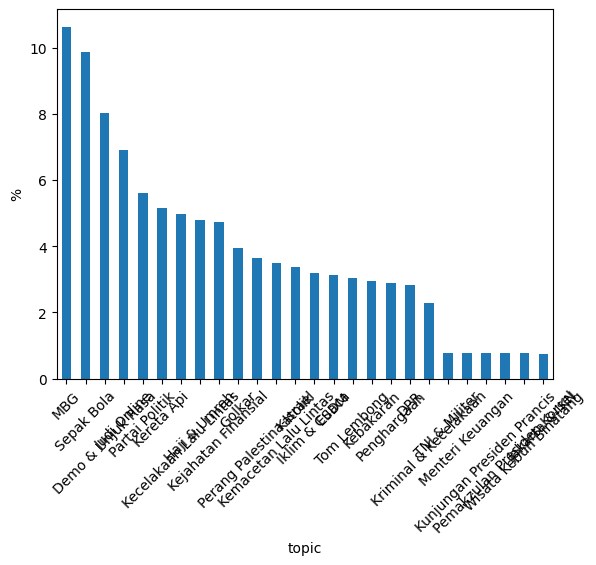

In [102]:
import matplotlib.pyplot as plt

df[df["topic"].notna()]["topic"].value_counts(normalize=True).mul(100).sort_values(ascending=False).plot(kind="bar", rot=45, ylabel="%")

In [103]:
df[df["topic"].notna()][["Judul", "Waktu", "Link", "Content", *TAG_COLS, "source", "topic"]].to_csv("dataset/news_with_topics.csv", index=False)